In [ ]:
# Importacoes
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import ta
import matplotlib.pyplot as plt


In [ ]:
# Carregar e limpar os dados
df = pd.read_csv("Dados Históricos - Ibovespa (4).csv")
df.columns = ['Data', 'Fechamento', 'Abertura', 'Alta', 'Baixa', 'Vol', 'Var%']
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df = df.sort_values('Data', ascending=False)
df['Var%'] = df['Var%'].str.replace('%','').str.replace(',','.').astype(float)
df['Fechamento'] = df['Fechamento'].astype(str).str.replace('.', '').str.replace(',', '.').astype(float)

In [ ]:
# Target: prever se o dia seguinte será maior que o atual
df['Target'] = (df['Fechamento'].shift(-1) > df['Fechamento']).astype(int)

In [20]:
# Features
df['Media_5'] = df['Fechamento'].rolling(5).mean()
df['Media_10'] = df['Fechamento'].rolling(10).mean()
df['Vol_5'] = df['Var%'].rolling(5).std()
df['RSI'] = ta.momentum.RSIIndicator(close=df['Fechamento'], window=14).rsi()
macd = ta.trend.MACD(close=df['Fechamento'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()
df.dropna(inplace=True)

features = ['Var%', 'Media_5', 'Media_10', 'Vol_5', 'RSI', 'MACD', 'MACD_signal']
X = df[features].values
y = df['Target'].values

In [ ]:
X = df[features]  # mantém como DataFrame, não como array
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # X_scaled pode ser array, mas o fit foi feito com colunas


In [ ]:
# Separação treino e teste
X_treino, X_teste = X_scaled[:-30], X_scaled[-30:]
y_treino, y_teste = y[:-30], y[-30:]
print('O dataset de treino possui {} dias e o de teste {} dias.'.format(X_treino.shape[0], X_teste.shape[0]))

O dataset de treino possui 936 dias e o de teste 30 dias.


In [23]:
model = LogisticRegression(penalty='l1', C=1, solver='liblinear', max_iter=1000)
model.fit(X_treino, y_treino)

LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='liblinear')

In [24]:
# Previsão
y_pred = model.predict(X_teste)

In [25]:
# Avaliação
print(f"Acurácia Modelo RL: {accuracy_score(y_teste, y_pred)*100:.2f}%\n")
print(classification_report(y_teste, y_pred))

Acurácia Modelo RL: 86.67%

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.86      0.86      0.86        14

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.87      0.87      0.87        30



In [26]:
cm = confusion_matrix(y_teste, y_pred)

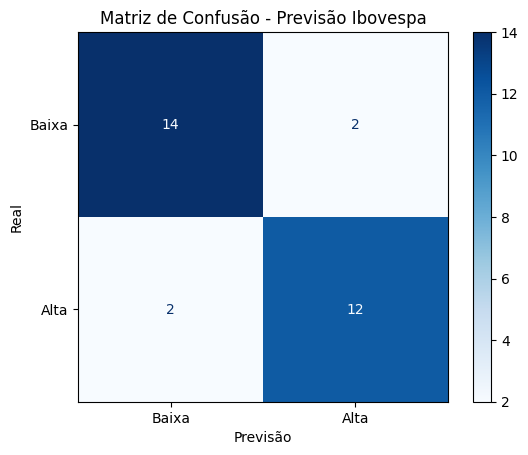

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Baixa", "Alta"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - Previsão Ibovespa")
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.show()

In [ ]:
# Separar treino/validação e teste (últimos 30 dias são o teste final)
X_treino_total = X_scaled[:-30]
y_treino_total = y[:-30]
X_teste = X_scaled[-30:]
y_teste = y[-30:]

# Dividir X_treino_total em treino + validação
X_train, X_val, y_train, y_val = train_test_split(X_treino_total, y_treino_total, test_size=0.2, shuffle=False)

# Parâmetros a testar
penalties = {
    'L1': {'penalty': 'l1', 'solver': 'liblinear'},
    'L2': {'penalty': 'l2', 'solver': 'lbfgs'}
}

C_values = [0.01, 0.1, 1, 10]

# Guardar resultados
results = []

print(f"{'Penalty':<10}{'C':<6}{'Acurácia Treino':<20}{'Acurácia Validação'}")
print("="*60)

for name, config in penalties.items():
    for C in C_values:
        params = {
            'penalty': config['penalty'],
            'solver': config['solver'],
            'max_iter': 1000,
            'C': C
        }

        try:
            model = LogisticRegression(**params)
            model.fit(X_train, y_train)

            acc_train = accuracy_score(y_train, model.predict(X_train))
            acc_val = accuracy_score(y_val, model.predict(X_val))

            print(f"{name:<10}{C:<6}{acc_train*100:<20.2f}{acc_val*100:.2f}")

            results.append({
                'penalty': name,
                'C': C,
                'acc_train': acc_train,
                'acc_val': acc_val,
                'model': model  
            })

        except Exception as e:
            print(f"{name:<10}{C:<6}Erro: {str(e)}")

# Escolher o melhor modelo com base na validação
best_model_info = max(results, key=lambda x: x['acc_val'])
best_model = best_model_info['model']

print("\nMelhor modelo na validação:")
print(f"Penalty: {best_model_info['penalty']}, C: {best_model_info['C']}")
print(f"Acurácia na validação: {best_model_info['acc_val']*100:.2f}%")

# Avaliar no conjunto de teste (últimos 30 dias)
y_pred_test = best_model.predict(X_teste)
acc_test = accuracy_score(y_teste, y_pred_test)

print(f"\nAcurácia no teste final (últimos 30 dias): {acc_test*100:.2f}%")

Penalty   C     Acurácia Treino     Acurácia Validação
L1        0.01  50.53               50.00
L1        0.1   85.83               88.83
L1        1     88.10               89.36
L1        10    88.50               87.23
L2        0.01  69.52               71.28
L2        0.1   75.80               81.38
L2        1     85.16               88.83
L2        10    87.70               87.77

Melhor modelo na validação:
Penalty: L1, C: 1
Acurácia na validação: 89.36%

Acurácia no teste final (últimos 30 dias): 86.67%
